In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from datetime import datetime
import networkx as nx
import statsmodels.api as sm

sys.path.insert(0, str(Path.cwd().parent))

from src.behavior_import.import_data import *
from src.behavior_import.extract_trials import *
from src.behavior_import.filter_trials_by_subject import *
from src.behavior_import.filter_trials_by_session import *
from src.behavior_analysis.get_good_reversal_info import *
from src.behavior_analysis.get_choice_probs_around_good_reversals import *
from src.behavior_analysis.split_early_late_good_reversals import *
from src.behavior_analysis.get_first_leave_after_good_reversals import *
from src.behavior_analysis.get_rank_counts_by_good_reversal import *
from src.behavior_analysis.get_bad_reversal_info import *
from src.behavior_analysis.get_diagnostic_p_value import *
from src.behavior_visualization.plot_num_reversals import *
from src.behavior_visualization.plot_first_leave_after_good_reversals import *
from src.behavior_visualization.plot_choice_probs_around_good_reversals import *
from src.behavior_visualization.plot_rank_proportions import *

In [2]:
root = "../data/cohort-02/rawdata/"
subjects_data = import_data(root)

[INFO] Processed 6 subjects(s), 159 session(s).


In [3]:
subjects_trials = extract_trials(subjects_data)

[INFO] Merging multiple files for subject MY_05_L, session ses-8_date-20260114
[INFO] Merging multiple files for subject MY_05_L, session ses-9_date-20260115
[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[INFO] Merging multiple files for subject MY_05_N, session ses-2_date-20260111


In [4]:
sessions_to_keep = ["ses-01_date-20260111", "ses-02_date-20260111",
                    "ses-03_date-20260112", "ses-04_date-20260112",
                    "ses-05_date-20260113", "ses-06_date-20260113",
                    "ses-07_date-20260114", "ses-08_date-20260114",
                    "ses-09_date-20260115", "ses-10_date-20260115",
                    "ses-11_date-20260116", "ses-12_date-20260116",
                    "ses-13_date-20260117", "ses-14_date-20260117",
                    "ses-15_date-20260118", "ses-16_date-20260118"]
# subjects_to_keep = ["MY_04_N", "MY_04_L", "MY_04_R", "MY_05_N", "MY_05_R"]
subjects_trials = filter_trials_by_session(subjects_trials, sessions_to_keep)
# subjects_trials = filter_trials_by_subject(subjects_trials, subjects_to_keep)

In [4]:
sessions_to_keep = ["ses-17_date-20260119", "ses-18_date-20260119",
                    "ses-19_date-20260120", "ses-20_date-20260120",
                    "ses-21_date-20260121", "ses-22_date-20260121",
                    "ses-23_date-20260122", "ses-24_date-20260122",
                    "ses-25_date-20260123", "ses-26_date-20260123",
                    "ses-27_date-20260124", "ses-28_date-20260124",
                    "ses-29_date-20260125", "ses-30_date-20260125"]
# subjects_to_keep = ["MY_04_N", "MY_04_L", "MY_04_R", "MY_05_N", "MY_05_R"]
subjects_trials = filter_trials_by_session(subjects_trials, sessions_to_keep)
# subjects_trials = filter_trials_by_subject(subjects_trials, subjects_to_keep)

In [ ]:
reversal_windows = get_good_reversal_info(subjects_trials, include_first_block=True)
rank_counts_by_good_reversal = get_rank_counts_by_good_reversal(reversal_windows)
p_values = pvalue_paired_t_best_vs_second_vs_third(rank_counts_by_good_reversal)
plot_rank_proportions(rank_counts_by_good_reversal, average_across_mice_pvalues=p_values)

In [ ]:
reversal_windows = get_good_reversal_info(subjects_trials)
early, late = split_good_reversals_early_late(reversal_windows, first_n=2)
first_leave_per_subject = get_first_leave_after_good_reversals(late)
mean, se, n_subjects = average_first_leave_across_subjects(first_leave_per_subject)
p_value = pvalue_paired_t_new_vs_third(first_leave_per_subject, alternative="greater")
plot_first_leave_after_good_reversals(mean, se, first_leave_per_subject, p_value, save_path=None)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.lines import Line2D


def plot_block_lengths_median_across_mice(good_reversal_info, colors, show_lines=True,
    jitter=0.0,          
    bar_color="0.8",     
    bar_edge="0.35",
    bar_lw=2.0,
):
    """
    Bars: median block length across mice for each block number.
    Error bars: SE across mice for each block number.
    Points/lines: per-mouse block lengths in the provided colors.

    Block length is computed from successive reversal_idx boundaries:
        L_b = reversal_idx[b+1] - reversal_idx[b]
    The final block per mouse is dropped (no end boundary).
    """

    # ---- 1) per-mouse block lengths by block number ----
    per_mouse_blocklens = {}
    for mouse, rev_list in good_reversal_info.items():
        if not rev_list:
            continue

        rev_sorted = sorted(rev_list, key=lambda r: r["reversal_idx"])
        rev_idxs = [r["reversal_idx"] for r in rev_sorted]

        if len(rev_idxs) < 2:
            continue

        lens = [rev_idxs[i + 1] - rev_idxs[i] for i in range(len(rev_idxs) - 1)]
        per_mouse_blocklens[mouse] = {b + 1: float(L) for b, L in enumerate(lens)}

    if not per_mouse_blocklens:
        raise ValueError("No block lengths computed. Need >=2 reversal boundaries per mouse.")

    # ---- 2) aggregate across mice per block number ----
    block_to_vals = defaultdict(list)
    for mouse, bl in per_mouse_blocklens.items():
        for b, L in bl.items():
            if np.isfinite(L):
                block_to_vals[b].append(L)

    blocks = sorted(block_to_vals.keys())
    meds = np.array([np.median(block_to_vals[b]) for b in blocks], dtype=float)

    # SE across mice (ddof=1 if >=2 mice have that block)
    ses = []
    for b in blocks:
        vals = np.asarray(block_to_vals[b], dtype=float)
        if len(vals) >= 2:
            ses.append(np.std(vals, ddof=1) / np.sqrt(len(vals)))
        else:
            ses.append(0.0)
    ses = np.asarray(ses, dtype=float)

    # ---- 3) plot ----
    fig, ax = plt.subplots(figsize=(10, 4.5))

    # Bars
    ax.bar(
        blocks, meds,
        color=bar_color,
        edgecolor=bar_edge,
        linewidth=bar_lw,
        zorder=1
    )

    # Error bars (black)
    ax.errorbar(
        blocks, meds, yerr=ses,
        fmt="none",
        ecolor="black",
        elinewidth=2.5,
        capsize=8,
        capthick=2.5,
        zorder=3
    )

    # Mouse colors (stable mapping)
    mice = sorted(per_mouse_blocklens.keys())
    mouse_to_color = {m: colors[i % len(colors)] for i, m in enumerate(mice)}

    # Per-mouse points (and optional connecting lines)
    for m in mice:
        c = mouse_to_color[m]
        xs, ys = [], []
        for b in blocks:
            if b in per_mouse_blocklens[m]:
                xs.append(b)
                ys.append(per_mouse_blocklens[m][b])

        if not xs:
            continue

        xs = np.asarray(xs, dtype=float)
        ys = np.asarray(ys, dtype=float)

        if jitter > 0:
            xs = xs + np.random.uniform(-jitter, jitter, size=len(xs))

        if show_lines and len(xs) >= 2:
            ax.plot(xs, ys, color=c, linewidth=2.5, alpha=0.9, zorder=4)

        ax.scatter(xs, ys, s=70, color=c, edgecolor="white", linewidth=0.8, zorder=5)

    # ---- 4) styling like your reversal plot ----
    ax.set_title(title, fontsize=16, pad=12)
    ax.set_xlabel("Block number", fontsize=16)
    ax.set_ylabel("Block length (trials)", fontsize=16)

    ax.set_xticks(blocks)
    ax.tick_params(axis="both", labelsize=13)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Legend: one handle per mouse (prevents the “two colors” issue)
    handles = [
        Line2D([0], [0], marker="o", linestyle="-",
               color=mouse_to_color[m], markerfacecolor=mouse_to_color[m],
               markeredgecolor="white", markeredgewidth=0.8,
               linewidth=2.5, markersize=9, label=m)
        for m in mice
    ]
    ax.legend(handles=handles, loc="upper right", frameon=True, fontsize=11)

    plt.tight_layout()
    plt.show()

    return per_mouse_blocklens, block_to_vals

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[SKIP] MY_05_L reversal@401 (block 8): reward magnitudes before reversal were [4, 0, 0] across towers ['A3', 'A1', 'C3'] (expected a permutation of [4, 1, 0])


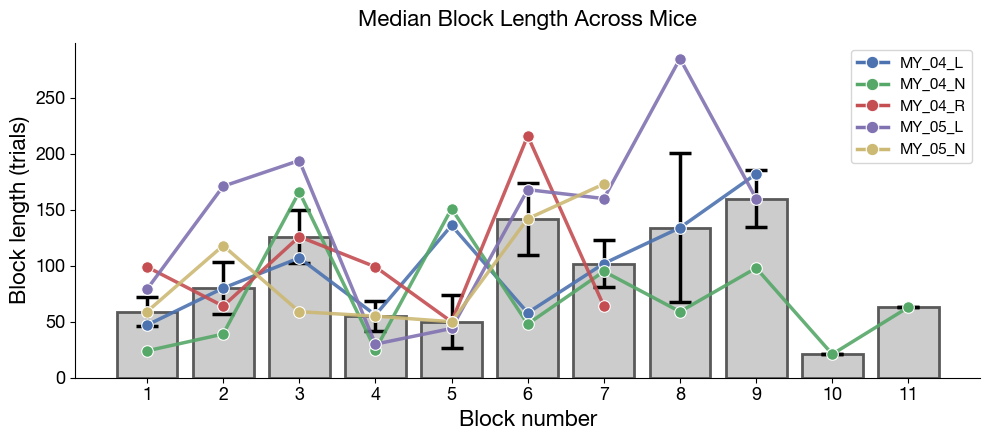

In [15]:
good_reversal_info = get_good_reversal_info(subjects_trials, include_first_block=True)

per_mouse_blocklens, block_to_vals = plot_block_lengths_median_across_mice(
    good_reversal_info,
    colors=[
        "#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD", "#8C8C8C"
    ],
    title="Median Block Length Across Mice"
)


In [ ]:
bad_reversals = get_bad_reversal_info(subjects_trials, include_first_block=True)

In [30]:
merged, _ = get_vars_across_all_sessions(subjects_trials)

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111


In [32]:
merged['MY_04_L'].keys()

dict_keys(['trial', 'good_reversals', 'bad_reversals', 'blocks', 'trials_in_block', 'reward_magnitudes_by_tower', 'choices_by_tower', 'choices_by_rank'])

In [4]:
def make_arm_mapping(tower_keys):
    """Deterministic mapping: sorted tower keys -> Arm1/Arm2/Arm3."""
    keys_sorted = sorted(list(tower_keys))
    return {k: f"Arm{i+1}" for i, k in enumerate(keys_sorted)}

def remap_tower_dict_to_arms(d, mapping):
    """Remap {tower: list} -> {ArmX: list} using mapping[tower]."""
    out = {}
    for tower, arr in d.items():
        if tower in mapping:
            out[mapping[tower]] = arr
    return out

def get_chosen_reward_per_trial(choices_by_tower, reward_magnitudes_by_tower):
    """
    Returns:
        rewards: list length n_trials, where rewards[t] is the reward magnitude
                 of the chosen tower at trial t.

    Args:
        strict: if True, raises if a trial is not exactly one-hot.
                if False, returns fill_value for ambiguous/missing trials.
        fill_value: value to use when strict=False and choice is ambiguous/missing.
    """
    towers = list(reward_magnitudes_by_tower.keys())
    if not towers:
        return []

    # Use the minimum available length across towers to avoid IndexError
    n_trials = min(len(reward_magnitudes_by_tower[t]) for t in towers)

    # Ensure we have choice arrays for the same towers
    missing = [t for t in towers if t not in choices_by_tower]
    if missing:
        raise KeyError(f"choices_by_tower missing towers: {missing}")

    # Also ensure choice arrays are long enough
    n_trials = min(n_trials, *(len(choices_by_tower[t]) for t in towers))

    rewards = []
    for i in range(n_trials):
        chosen = [t for t in towers if choices_by_tower[t][i] == 1]

        if len(chosen) != 1:
            raise ValueError(f"Trial {i}: expected exactly one chosen tower, got {chosen}")

        t = chosen[0]
        rewards.append(reward_magnitudes_by_tower[t][i])

    return rewards

In [11]:
import numpy as np

def format_glm_input(data, input_dimension=29, drop_redundant_cols=True):
    merged_data_across_subjects, _ = get_vars_across_all_sessions(data)
    regressors_across_subjects = {}
    true_choices_across_subjects = {}

    # columns that are redundant given one-hot choice structure
    drop_cols = [3, 6, 9, 12, 19, 22, 25, 28]  # Arm3 for choices + Arm3 for interactions
    keep_cols = [i for i in range(input_dimension) if i not in drop_cols]

    for subject in merged_data_across_subjects.keys():
        current_subject_data = merged_data_across_subjects[subject]

        choices_by_tower = current_subject_data["choices_by_tower"]
        chosen_rewards = get_chosen_reward_per_trial(
            choices_by_tower,
            current_subject_data["reward_magnitudes_by_tower"]
        )

        tower_to_arm = make_arm_mapping(choices_by_tower.keys())
        choices_by_arm = remap_tower_dict_to_arms(choices_by_tower, tower_to_arm)

        num_trials = len(current_subject_data["trial"])
        regressors = np.zeros((num_trials, input_dimension))
        true_choices = np.zeros((num_trials, len(choices_by_tower.keys())))

        for t in range(1, num_trials):
            # explicit ordering = Arm1, Arm2, Arm3
            true_choices[t, :] = [
                choices_by_arm["Arm1"][t],
                choices_by_arm["Arm2"][t],
                choices_by_arm["Arm3"][t],
            ]

            regressors[t, 0] = 1  # Bias term

            # lag 1
            regressors[t, 1] = choices_by_arm["Arm1"][t - 1]
            regressors[t, 2] = choices_by_arm["Arm2"][t - 1]
            regressors[t, 3] = choices_by_arm["Arm3"][t - 1]
            regressors[t, 13] = chosen_rewards[t - 1]
            regressors[t, 17] = choices_by_arm["Arm1"][t - 1] * chosen_rewards[t - 1]
            regressors[t, 18] = choices_by_arm["Arm2"][t - 1] * chosen_rewards[t - 1]
            regressors[t, 19] = choices_by_arm["Arm3"][t - 1] * chosen_rewards[t - 1]

            # lag 2
            if t >= 2:
                regressors[t, 4] = choices_by_arm["Arm1"][t - 2]
                regressors[t, 5] = choices_by_arm["Arm2"][t - 2]
                regressors[t, 6] = choices_by_arm["Arm3"][t - 2]
                regressors[t, 14] = chosen_rewards[t - 2]
                regressors[t, 20] = choices_by_arm["Arm1"][t - 2] * chosen_rewards[t - 2]
                regressors[t, 21] = choices_by_arm["Arm2"][t - 2] * chosen_rewards[t - 2]
                regressors[t, 22] = choices_by_arm["Arm3"][t - 2] * chosen_rewards[t - 2]

            # lag 3
            if t >= 3:
                regressors[t, 7] = choices_by_arm["Arm1"][t - 3]
                regressors[t, 8] = choices_by_arm["Arm2"][t - 3]
                regressors[t, 9] = choices_by_arm["Arm3"][t - 3]
                regressors[t, 15] = chosen_rewards[t - 3]
                regressors[t, 23] = choices_by_arm["Arm1"][t - 3] * chosen_rewards[t - 3]
                regressors[t, 24] = choices_by_arm["Arm2"][t - 3] * chosen_rewards[t - 3]
                regressors[t, 25] = choices_by_arm["Arm3"][t - 3] * chosen_rewards[t - 3]

            # lag 4
            if t >= 4:
                regressors[t, 10] = choices_by_arm["Arm1"][t - 4]
                regressors[t, 11] = choices_by_arm["Arm2"][t - 4]
                regressors[t, 12] = choices_by_arm["Arm3"][t - 4]
                regressors[t, 16] = chosen_rewards[t - 4]
                regressors[t, 26] = choices_by_arm["Arm1"][t - 4] * chosen_rewards[t - 4]
                regressors[t, 27] = choices_by_arm["Arm2"][t - 4] * chosen_rewards[t - 4]
                regressors[t, 28] = choices_by_arm["Arm3"][t - 4] * chosen_rewards[t - 4]

        # drop first trial (no history)
        regressors = regressors[1:, :]
        true_choices = true_choices[1:, :]

        # drop redundant columns to make X full rank
        if drop_redundant_cols:
            regressors = regressors[:, keep_cols]

        regressors_across_subjects[subject] = regressors
        true_choices_across_subjects[subject] = true_choices

    return regressors_across_subjects, true_choices_across_subjects, keep_cols

In [9]:
def format_glm_input(data, input_dimension=29):
    merged_data_across_subjects, _ = get_vars_across_all_sessions(data)
    regressors_across_subjects = {}
    true_choices_across_subjects = {}
    for subject in merged_data_across_subjects.keys():
        current_subject_data = merged_data_across_subjects[subject]

        choices_by_tower = current_subject_data["choices_by_tower"]
        chosen_rewards = get_chosen_reward_per_trial(choices_by_tower, current_subject_data["reward_magnitudes_by_tower"])

        tower_to_arm = make_arm_mapping(choices_by_tower.keys())
        choices_by_arm = remap_tower_dict_to_arms(choices_by_tower, tower_to_arm)

        num_trials = len(current_subject_data['trial'])
        regressors = np.zeros((num_trials, input_dimension))
        true_choices = np.zeros((num_trials, len(choices_by_tower.keys())))

        # Fill input features
        # 0: bias
        # 1: prev choice arm 1
        # 2: prev choice arm 2
        # 3: prev choice arm 3
        # 4: n - 1 choice arm 1
        # 5: n - 1 choice arm 2
        # 6: n - 1 choice arm 3
        # 7: n - 2 choice arm 1
        # 8: n - 2 choice arm 2
        # 9: n - 2 choice arm 3
        # 10: n - 3 choice arm 1
        # 11: n - 3 choice arm 2
        # 12: n - 3 choice arm 3
        # 13: prev reward
        # 14: n - 1 reward
        # 15: n - 2 reward
        # 16: n - 3 reward
        # 17: prev choice arm 1 x reward
        # 18: prev choice arm 2 x reward
        # 19: prev choice arm 3 x reward
        # 20: n - 1 choice arm 1 x reward
        # 21: n - 1 choice arm 2 x reward
        # 22: n - 1 choice arm 3 x reward
        # 23: n - 2 choice arm 1 x reward
        # 24: n - 2 choice arm 2 x reward
        # 25: n - 2 choice arm 3 x reward
        # 26: n - 3 choice arm 1 x reward
        # 27: n - 3 choice arm 2 x reward
        # 28: n - 3 choice arm 3 x reward
        for t in range(1, num_trials):
            true_choices[t, :] = [choices_by_arm[arm][t] for arm in sorted(choices_by_arm.keys())]

            regressors[t, 0] = 1  # Bias term
            regressors[t, 1] = choices_by_arm['Arm1'][t-1]
            regressors[t, 2] = choices_by_arm['Arm2'][t-1]
            regressors[t, 3] = choices_by_arm['Arm3'][t-1]
            regressors[t, 13] = chosen_rewards[t-1]
            regressors[t, 17] = choices_by_arm['Arm1'][t-1] * chosen_rewards[t-1]
            regressors[t, 18] = choices_by_arm['Arm2'][t-1] * chosen_rewards[t-1]
            regressors[t, 19] = choices_by_arm['Arm3'][t-1] * chosen_rewards[t-1]

            if t >= 2:
                regressors[t, 4] = choices_by_arm['Arm1'][t-2]
                regressors[t, 5] = choices_by_arm['Arm2'][t-2]
                regressors[t, 6] = choices_by_arm['Arm3'][t-2]
                regressors[t, 14] = chosen_rewards[t-2]
                regressors[t, 20] = choices_by_arm['Arm1'][t-2] * chosen_rewards[t-2]
                regressors[t, 21] = choices_by_arm['Arm2'][t-2] * chosen_rewards[t-2]
                regressors[t, 22] = choices_by_arm['Arm3'][t-2] * chosen_rewards[t-2]
            if t >= 3:
                regressors[t, 7] = choices_by_arm['Arm1'][t-3]
                regressors[t, 8] = choices_by_arm['Arm2'][t-3]
                regressors[t, 9] = choices_by_arm['Arm3'][t-3]
                regressors[t, 15] = chosen_rewards[t-3]
                regressors[t, 23] = choices_by_arm['Arm1'][t-3] * chosen_rewards[t-3]
                regressors[t, 24] = choices_by_arm['Arm2'][t-3] * chosen_rewards[t-3]
                regressors[t, 25] = choices_by_arm['Arm3'][t-3] * chosen_rewards[t-3]
            if t >= 4:
                regressors[t, 10] = choices_by_arm['Arm1'][t-4]
                regressors[t, 11] = choices_by_arm['Arm2'][t-4]
                regressors[t, 12] = choices_by_arm['Arm3'][t-4]
                regressors[t, 16] = chosen_rewards[t-4]
                regressors[t, 26] = choices_by_arm['Arm1'][t-4] * chosen_rewards[t-4]
                regressors[t, 27] = choices_by_arm['Arm2'][t-4] * chosen_rewards[t-4]
                regressors[t, 28] = choices_by_arm['Arm3'][t-4] * chosen_rewards[t-4]
        regressors = regressors[1:, :]
        true_choices = true_choices[1:, :]
        regressors_across_subjects[subject] = regressors
        true_choices_across_subjects[subject] = true_choices
    return regressors_across_subjects, true_choices_across_subjects

In [12]:
regressors_across_subjects, true_choices_across_subjects, keep_cols = format_glm_input(subjects_data)

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111


In [21]:
for subject in regressors_across_subjects.keys():
    X = regressors_across_subjects[subject]
    y = true_choices_across_subjects[subject]

    model = sm.MNLogit(y, X)
    result = model.fit(method="newton", maxiter=100, disp=False)

    print(f"Subject: {subject}")
    print(result.summary())
    print("\n")

Subject: MY_04_N
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  912
Model:                        MNLogit   Df Residuals:                      870
Method:                           MLE   Df Model:                           40
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                 0.09688
Time:                        16:54:19   Log-Likelihood:                -904.15
converged:                       True   LL-Null:                       -1001.1
Covariance Type:            nonrobust   LLR p-value:                 4.305e-22
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1367      0.357      0.383      0.702      -0.562       0.836
x1             0.4022      0.365      1.103      0.270      -0.312       1.117
x2             0.8202      0.371   

In [15]:
regressor_names = [
    "choice1", "choice2", "reward", "reward x choice1", "reward x choice2",
    "n-1 choice1", "n-1 choice2", "n-1 reward", "n-1 reward x choice1", "n-1 reward x choice2",
    "n-2 choice1", "n-2 choice2", "n-2 reward", "n-2 reward x choice1", "n-2 reward x choice2",
    "n-3 choice1", "n-3 choice2", "n-3 reward", "n-3 reward x choice1", "n-3 reward x choice2"
]

for subject in regressors_across_subjects:
    X = np.asarray(regressors_across_subjects[subject][:, 1:])
    y = np.asarray(true_choices_across_subjects[subject][:, 1:])

    assert X.shape[1] == len(regressor_names), (X.shape[1], len(regressor_names))

    X_df = pd.DataFrame(X, columns=regressor_names)
    X_df = sm.add_constant(X_df, has_constant="add")

    model = sm.MNLogit(y, X_df)
    res = model.fit(method="newton", maxiter=100, disp=False)

    print(subject)
    print(res.summary())


MY_04_R
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1094
Model:                        MNLogit   Df Residuals:                     1073
Method:                           MLE   Df Model:                           20
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                  0.3042
Time:                        17:04:09   Log-Likelihood:                -450.50
converged:                       True   LL-Null:                       -647.44
Covariance Type:            nonrobust   LLR p-value:                 3.783e-71
                 y=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7764      0.361     -2.153      0.031      -1.483      -0.070
choice1                  0.2763      0.322      0.857      0.391      -0.355       0.908
choi

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

regressor_names = [
    "choice1", "choice2", "reward", "reward_x_choice1", "reward_x_choice2",
    "n1_choice1", "n1_choice2", "n1_reward", "n1_reward_x_choice1", "n1_reward_x_choice2",
    "n2_choice1", "n2_choice2", "n2_reward", "n2_reward_x_choice1", "n2_reward_x_choice2",
    "n3_choice1", "n3_choice2", "n3_reward", "n3_reward_x_choice1", "n3_reward_x_choice2"
]

X_all = []
y_all = []

for subject in regressors_across_subjects:
    X = np.asarray(regressors_across_subjects[subject])

    # If your first column is bias/intercept, drop it (since we'll add const once)
    X = X[:, 1:]

    # y handling: choose ONE of these depending on your format:
    y_raw = np.asarray(true_choices_across_subjects[subject])
    if y_raw.ndim == 2:
        y = y_raw.argmax(axis=1).astype(int)   # one-hot -> labels
    else:
        y = y_raw.astype(int)

    assert X.shape[1] == len(regressor_names), (subject, X.shape, len(regressor_names))
    assert len(y) == X.shape[0], (subject, len(y), X.shape[0])

    X_df = pd.DataFrame(X, columns=regressor_names)
    X_df["subject"] = subject

    X_all.append(X_df)
    y_all.append(y)

X_all = pd.concat(X_all, ignore_index=True)
y_all = np.concatenate(y_all)

# Subject fixed effects (baseline differences)
X_all = pd.get_dummies(X_all, columns=["subject"], drop_first=True)

# Add intercept once
X_all = sm.add_constant(X_all, has_constant="add")

model = sm.MNLogit(y_all, X_all)
res = model.fit(method="newton", maxiter=200, disp=True)

print(res.summary())


In [14]:
X_by, Y_by, keep_cols = format_glm_input(subjects_trials)

X = X_by["MY_04_L"]
Y = Y_by["MY_04_L"]
y = np.argmax(Y, axis=1)

print("rank vs p:", np.linalg.matrix_rank(X), X.shape[1])  # should match

mn = sm.MNLogit(y, X)
res = mn.fit(method="bfgs", maxiter=500, disp=False)
print(res.summary())

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
rank vs p: 21 21
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1052
Model:                        MNLogit   Df Residuals:                     1010
Method:                           MLE   Df Model:                           40
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                 0.07093
Time:                        15:57:57   Log-Likelihood:                -1067.2
converged:                       True   LL-Null:                       -1148.6
Covariance Type:            nonrobust   LLR p-value:                 8.996e-17
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5848      0.318      1.839      0.066      -0.038       1.208
x1            -0.5852      0